# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
import matplotlib.pyplot as plt
import math as m
%matplotlib inline

In [2]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset

data, attrs = fetch_lfw_dataset(use_raw=True,)

In [3]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [4]:
X_train = data[:10000, :44, :44]#.reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:, :44, :44]#.reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = X_train.shape[1]
image_w = X_train.shape[2]

(10000, 44, 44, 3)
(3143, 44, 44, 3)


In [5]:
def plot_gallery(images, h=image_h, w=image_w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.show()

In [6]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [7]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

# Homework: Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [15]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 4

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

inp_enc = tf.keras.Input(X_train.shape[1:])
x = L.Conv2D(64, 5, activation="relu", strides=3, padding="valid")(inp_enc)
x = L.Conv2D(128, 5, activation="relu", strides=3, padding="valid")(x)
x = L.Flatten()(x)
mu_enc = L.Dense(dimZ, name='mu_encoder')(x)
sigma_enc = L.Dense(dimZ, name='sigma_encoder')(x)

epsilon = tf.random.normal(tf.shape(mu_enc))
sampled_distr = mu_enc + tf.exp(0.5 * sigma_enc)*epsilon
encoder = tf.keras.Model(inputs = inp_enc, outputs = [mu_enc, sigma_enc, sampled_distr]) # output should be mean, variance and a sample

inp_dec = tf.keras.Input(dimZ)
x = L.Dense(2048, activation = 'relu')(inp_dec)
x = L.Reshape((4, 4, 128))(x)
x = L.Conv2DTranspose(64, 5, activation="relu", strides=3, padding="valid")(x)
reconstr = L.Conv2DTranspose(3, 5, activation="sigmoid", strides=3, padding="valid")(x)

#reconstr = L.Dense(X_train.shape[1], activation ='sigmoid', name='reconstructed_image')(x)
#log_sigma_decoder = L.Dense(X_train.shape[1], name='log_sigma_decoder')(x)

decoder = tf.keras.Model(inputs = inp_dec, outputs = reconstr)

In [16]:
encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 44, 44, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   4864        ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 4, 4, 128)    204928      ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 2048)         0           ['conv2d_3[0][0]']               
                                                                                            

In [17]:
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              10240     
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 44, 44, 3)        4803      
 ranspose)                                                       
                                                                 
Total params: 219,907
Trainable params: 219,907
Non-trainab

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [18]:
from tensorflow.keras.optimizers import Adam

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.optimizer = Adam()
        
    @tf.function
    def KL_divergence(self, mu, log_sigma):
        kl_loss = -0.5 * tf.reduce_sum(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma), axis=1)
        return tf.reduce_mean(kl_loss)

    @tf.function
    def log_likelihood(self, x, z, mu, log_sigma):
        """
        x = tf.reshape(x, (-1, x.shape[1], 1))
        mu = tf.reshape(mu, (-1, 1, mu.shape[1]))
        log_sigma = tf.reshape(log_sigma, (-1, 1, log_sigma.shape[1]))
        #pi = tf.Variable(m.pi)
        recon_loss = tf.math.log(1/tf.math.sqrt(2*m.pi)) - log_sigma - tf.square(mu - x)/(2*tf.square(tf.math.exp(log_sigma)))
        recon_loss = tf.reduce_sum(recon_loss, axis=2)
        """
        recon_loss = 0.5 * tf.reduce_sum(tf.square(x - z), axis=(1,2,3))
        #recon_loss = -tf.reduce_sum(x * tf.math.log(z) + (1 - x) * tf.math.log(1 - z), axis=1)/2
        return tf.reduce_mean(recon_loss)

    def train_step(self, data):
        x = data[0]
        
        with tf.GradientTape() as tape:
            mu, log_sigma, sample1 = self.encoder(x)
            reconstructed_x = self.decoder(sample1)

            kl_loss = self.KL_divergence(mu, log_sigma)
            reconstruction_loss = self.log_likelihood(x, reconstructed_x, mu, log_sigma)
            total_loss = reconstruction_loss + kl_loss
            print(kl_loss, reconstruction_loss)

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return { 'loss': total_loss, 'kl_loss':kl_loss, 'reconstruction_loss':reconstruction_loss }
    
        
    def call(self, inputs):
        mu, log_sigma, z = self.encoder(inputs)

        reconstructed = self.decoder(z)

        return reconstructed

In [19]:
X_train.shape

(10000, 44, 44, 3)

In [20]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())#.Adagrad())
callback = DisplayCallback(vae, 2)

And train the model:

Epoch 1/10
Tensor("PartitionedCall:0", shape=(), dtype=float32) Tensor("PartitionedCall_1:0", shape=(), dtype=float32)
Tensor("PartitionedCall:0", shape=(), dtype=float32) Tensor("PartitionedCall_1:0", shape=(), dtype=float32)
310/313 [============================>.] - ETA: 0s - loss: 82.5616 - kl_loss: 1.7530 - reconstruction_loss: 80.8086

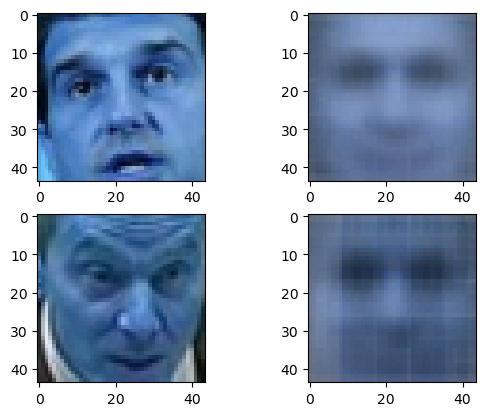

313/313 [==============================] - 3s 7ms/step - loss: 82.2909 - kl_loss: 1.8032 - reconstruction_loss: 80.4878
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 52.5813 - kl_loss: 5.4161 - reconstruction_loss: 47.1651
Epoch 3/10
312/313 [============================>.] - ETA: 0s - loss: 49.2419 - kl_loss: 5.7831 - reconstruction_loss: 43.4589

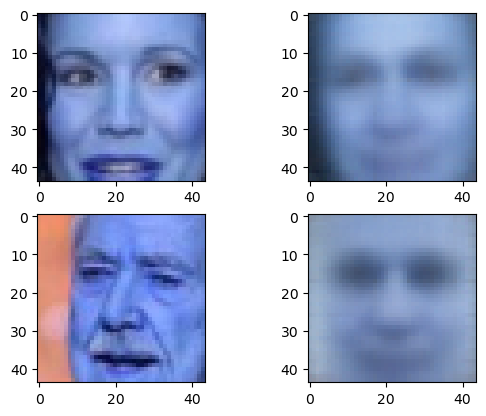

313/313 [==============================] - 2s 7ms/step - loss: 49.1927 - kl_loss: 5.7809 - reconstruction_loss: 43.4118
Epoch 4/10
313/313 [==============================] - 2s 6ms/step - loss: 48.7376 - kl_loss: 5.7972 - reconstruction_loss: 42.9404
Epoch 5/10
306/313 [============================>.] - ETA: 0s - loss: 48.4379 - kl_loss: 5.8524 - reconstruction_loss: 42.5855

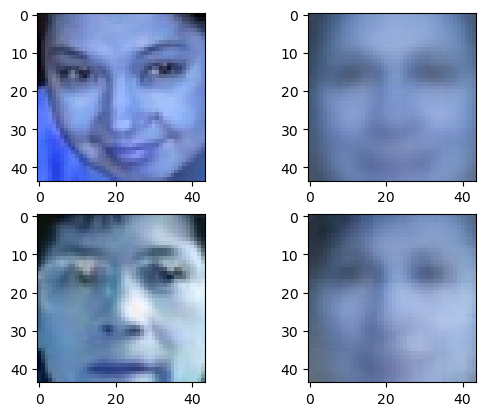

313/313 [==============================] - 2s 7ms/step - loss: 48.4249 - kl_loss: 5.8462 - reconstruction_loss: 42.5787
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 48.2193 - kl_loss: 5.8749 - reconstruction_loss: 42.3445
Epoch 7/10
307/313 [============================>.] - ETA: 0s - loss: 48.0805 - kl_loss: 5.8580 - reconstruction_loss: 42.2225

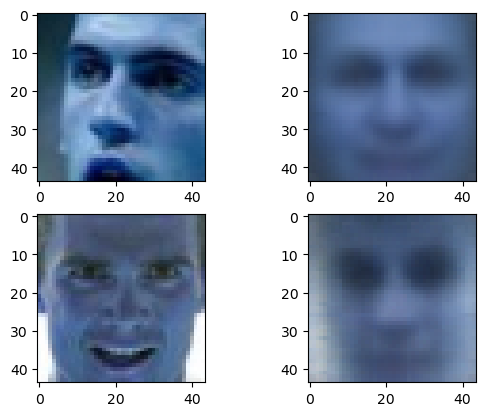

313/313 [==============================] - 2s 7ms/step - loss: 48.0385 - kl_loss: 5.8607 - reconstruction_loss: 42.1778
Epoch 8/10
313/313 [==============================] - 2s 6ms/step - loss: 47.9425 - kl_loss: 5.8693 - reconstruction_loss: 42.0732
Epoch 9/10
311/313 [============================>.] - ETA: 0s - loss: 47.9510 - kl_loss: 5.8574 - reconstruction_loss: 42.0936

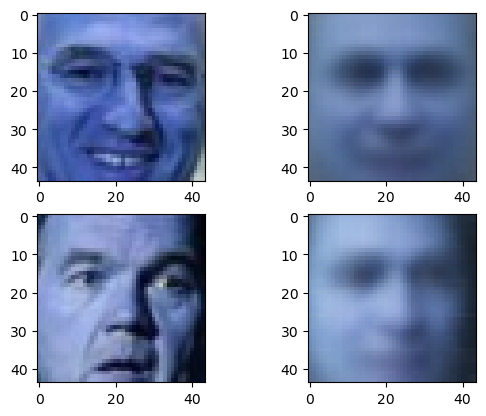

313/313 [==============================] - 2s 7ms/step - loss: 47.9433 - kl_loss: 5.8561 - reconstruction_loss: 42.0872
Epoch 10/10
313/313 [==============================] - 2s 6ms/step - loss: 47.8675 - kl_loss: 5.8838 - reconstruction_loss: 41.9837


In [21]:
#tf.compat.v1.enable_eager_execution()
history = vae.fit(X_train[:], X_train[:],
                  batch_size=32,
                  epochs=10,
                  callbacks=[callback])

Plot the learning curves

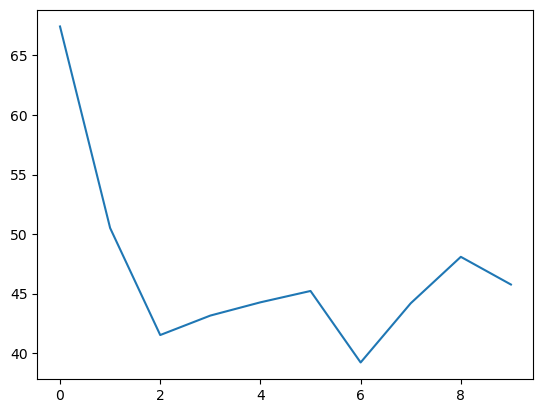

In [22]:
plt.plot(history.history['loss'])
plt.show()

And finally sample from VAE.

In [ ]:
# TODO
# Sample some images from the learned distribution

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

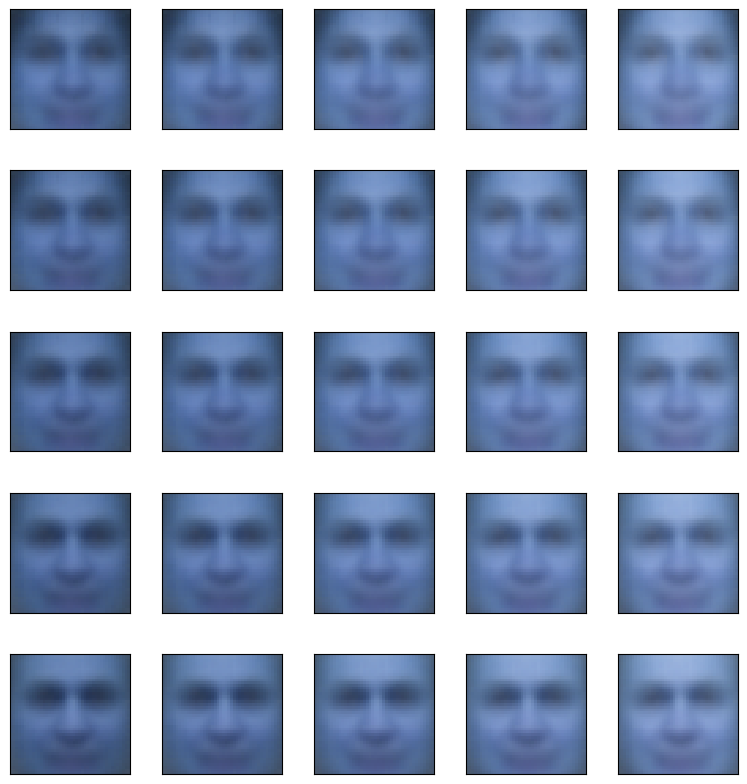

In [23]:
x=np.linspace(-1, 0.5, 5)
y=np.linspace(-1, 0.5, 5)
zeros = [0 for _ in range(dimZ-2)]
output=[]
for x1 in x:
    for y1 in y:
        output.append(decoder(np.array([[x1, y1]+zeros])).numpy())
plot_gallery(output, n_row=5, n_col=5)
plt.show()

# Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

<img src="linear.png" alt="linear">

In [30]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,-0.205363,-0.202842,-1.232735,-1.409125,-1.804858,0.287268,-0.521815,-0.789165,-1.008119,0.531813,...,-0.867156,-0.879554,-0.179497,0.323676,-2.188852,-1.169369,0.924397,-0.217415,-0.414024,-0.495178
13139,1.957472,-2.47247,-1.307994,-0.671636,-1.960125,-0.838803,-1.365955,0.510448,-1.262193,0.418947,...,-2.487289,2.608861,-0.95419,-1.599463,-1.23822,-1.187034,1.87413,-0.832614,0.152785,-0.554331
13140,-0.037001,-1.16415,0.228494,0.187503,-1.836475,-0.958412,-0.669697,-0.48033,0.493433,-1.893151,...,-1.938639,-0.49108,0.495067,-0.524767,-1.073731,0.11101,0.976262,-0.453027,-0.399981,-1.078655
13141,0.282219,-0.396198,1.27047,-1.981209,-1.70294,-1.507203,-2.330721,-0.295928,1.056618,-1.613698,...,-0.662101,-1.692131,1.284772,-0.80818,-0.710051,0.694621,0.936065,-0.7675,1.14693,-0.26094


In [36]:
attrs["Male"]

0        1.568346
1        0.169851
2        0.997749
3        1.122719
4        1.078214
           ...   
13138   -0.205363
13139    1.957472
13140   -0.037001
13141    0.282219
13142    0.071197
Name: Male, Length: 13143, dtype: object

In [46]:
smile_info = attrs.loc[:10000, "Pale Skin"].sort_values()
cnt_imgs = 10
smilers = smile_info[-cnt_imgs:]
frowners = smile_info[:cnt_imgs]

In [47]:
smilers_imgs = X_train[smilers.index]
frowners_imgs = X_train[frowners.index]

In [50]:
_, _, samples_smiler = encoder(smilers_imgs)
_, _, samples_frowner = encoder(frowners_imgs)

samples_avg_smiler = tf.reduce_mean(samples_smiler, axis=0)
samples_avg_frowner = tf.reduce_mean(samples_frowner, axis=0)

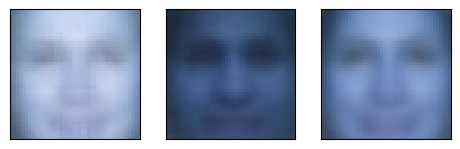

  pale                 dark                 mix


In [54]:
avg_smiler = decoder(np.array([samples_avg_smiler])).numpy()
avg_frowner = decoder(np.array([samples_avg_frowner])).numpy()
smile_imgs_all = np.append(avg_smiler, avg_frowner, axis=0)
avg_neutral = decoder(np.array([samples_avg_frowner+samples_avg_smiler])).numpy()
smile_imgs_all = np.append(smile_imgs_all, avg_neutral, axis=0)
plot_gallery(smile_imgs_all, n_row=1, n_col=3)
print('  pale',' '*15, 'dark', ' '*15, 'mix')

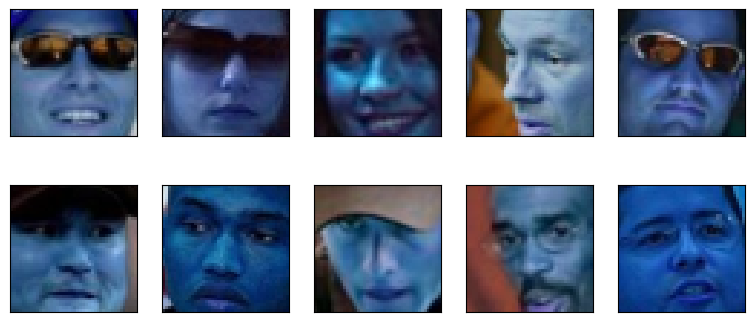

In [48]:
plot_gallery(frowners_imgs[:10], n_row=2, n_col=5)

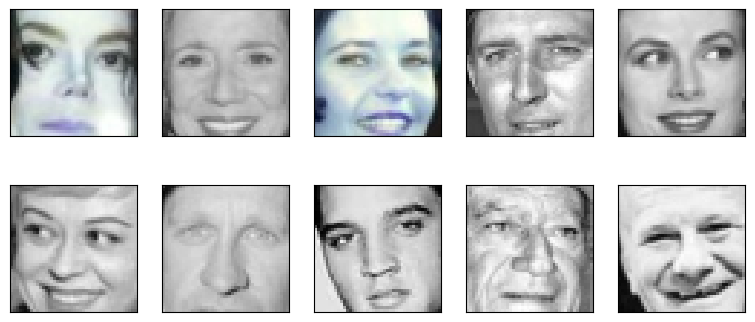

In [49]:
plot_gallery(smilers_imgs[:10], n_row=2, n_col=5)